In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

In [5]:
# ================================
# 1. Exploration et préparation des données
# ================================

# 1.1 Charger les données
df = pd.read_csv("./creditcard.csv")

print("Premières lignes :")
display(df.head())

print("Taille du dataset :", df.shape)

# Distribution de la variable cible
print("\nDistribution de la classe :")
print(df["Class"].value_counts(normalize=True) * 100)

# 1.2 Séparer X et y
X = df.drop("Class", axis=1)
y = df["Class"]

# 1.3 Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 1.4 Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Premières lignes :


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Taille du dataset : (284807, 31)

Distribution de la classe :
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [7]:
# ================================
# 2. Modèle de base : Régression Logistique
# ================================

# 2.1 Entraînement
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# 2.2 Prédictions
y_pred = model.predict(X_test_scaled)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy :", acc)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix :\n", cm)

# Precision, Recall, F1
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy : 0.9991397773954567
Confusion Matrix :
 [[56851    13]
 [   36    62]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.63      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



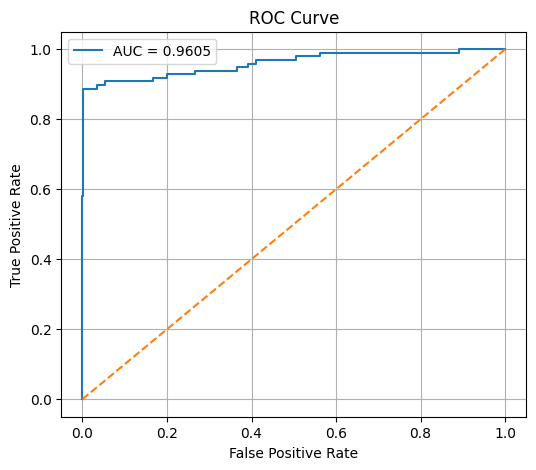

AUC-ROC : 0.9605494455801453


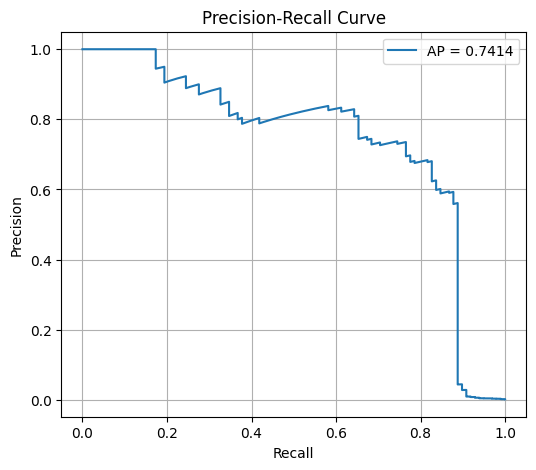

Average Precision (AP) : 0.7413820992780461


In [6]:
# ================================
# 3. ROC, AUC, Precision-Recall et AP
# ================================

# Probabilités
y_scores = model.predict_proba(X_test_scaled)[:, 1]

# 3.1 ROC + AUC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

print("AUC-ROC :", roc_auc)

# 3.2 Precision-Recall + Average Precision
precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

print("Average Precision (AP) :", ap)

In [3]:
# ================================
# 4. Comparaison de plusieurs modèles
# ================================
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score

rf_clf  = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

gb_clf  = GradientBoostingClassifier(random_state=42)

rf_clf.fit(X_train_scaled, y_train)
gb_clf.fit(X_train_scaled, y_train)

def compute_metrics(name, clf):
    if hasattr(clf, "predict_proba"):
        scores = clf.predict_proba(X_test_scaled)[:, 1]
    else:
        scores = clf.decision_function(X_test_scaled)

    # AUC-ROC
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_roc = auc(fpr, tpr)

    # Average Precision
    ap = average_precision_score(y_test, scores)

    # F1 for positive class, threshold=0.5
    y_pred_05 = (scores >= 0.5).astype(int)
    f1_pos = f1_score(y_test, y_pred_05, pos_label=1)

    print(f"\n=== {name} ===")
    print(f"AUC-ROC : {auc_roc:.4f}")
    print(f"AP      : {ap:.4f}")
    print(f"F1 (classe positive, seuil=0.5) : {f1_pos:.4f}")

    return {"AUC_ROC": auc_roc, "AP": ap, "F1_pos": f1_pos}

results = {}
results["LogisticRegression"] = compute_metrics("Logistic Regression", model)
results["RandomForest"]       = compute_metrics("Random Forest", rf_clf)
results["GradientBoosting"]   = compute_metrics("Gradient Boosting", gb_clf)

# 简单整理成表格看
results_df = pd.DataFrame(results).T
print("\nRésumé des métriques sur le test set :")
display(results_df)



=== Logistic Regression ===
AUC-ROC : 0.9605
AP      : 0.7414
F1 (classe positive, seuil=0.5) : 0.7168

=== Random Forest ===
AUC-ROC : 0.9572
AP      : 0.8590
F1 (classe positive, seuil=0.5) : 0.8457

=== Gradient Boosting ===
AUC-ROC : 0.3469
AP      : 0.1567
F1 (classe positive, seuil=0.5) : 0.2727

Résumé des métriques sur le test set :


,AUC_ROC,AP,F1_pos
LogisticRegression,0.960549,0.741382,0.716763
RandomForest,0.957194,0.858970,0.845714
GradientBoosting,0.346886,0.156654,0.272727


In [4]:
# ================================
# 5. Validation croisée et déséquilibre
# ================================
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline

# 5.1 选择一个最佳模型（举例：假设 Gradient Boosting 最好）
chosen_model = GradientBoostingClassifier(random_state=42)
# 如果你觉得别的更好，例如：RandomForest 或 LogisticRegression，改这一行即可：
# chosen_model = RandomForestClassifier(n_estimators=200, random_state=42,
#                                       n_jobs=-1, class_weight="balanced")
# chosen_model = LogisticRegression(max_iter=1000)

# 使用管道：StandardScaler + 模型
# （对树模型影响不大，但这样写对于所有模型都通用）
estimator = make_pipeline(StandardScaler(), chosen_model)

# StratifiedKFold：在每个折里保持正/负样本比例，适合不平衡数据
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 使用 average_precision（也可以改为 'roc_auc' 或 'f1'）
cv_scores = cross_val_score(
    estimator,
    X,          # 注意这里用的是完整的 X / y（未拆 train/test）
    y,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1
)

print("\nValidation croisée (5-fold) avec average_precision :")
print("Scores par fold :", cv_scores)
print(f"Moyenne : {cv_scores.mean():.4f}")
print(f"Écart-type : {cv_scores.std():.4f}")



Validation croisée (5-fold) avec average_precision :
Scores par fold : [0.66174582 0.62147223 0.68014784 0.58359036 0.16259186]
Moyenne : 0.5419
Écart-type : 0.1926
